In [106]:
import numpy as np
import tensorflow_probability as tfp
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd

In [107]:
class Gaussian:

    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        self.distr = tfp.distributions.Normal(self.mu, self.sigma)

    def pdf(self, x):
        return self.distr.prob(x)

    def cdf(self, x):
        return self.distr.cdf(x)

    def sample(self, n):
        return self.distr.sample(n)

    


In [108]:
np.random.seed(2)

mu1 = -2 # np.random.uniform(-10, 10)
sigma1 = 1 # np.random.uniform(1, 5)
f_1 = Gaussian(mu1, sigma1)
n1 = 150 # np.random.randint(100, 200)
cluster_1 = f_1.sample(n1)

mu2 = 4 # np.random.uniform(-10, 10)
sigma2 = 2 # np.random.uniform(1, 5)
f_2 = Gaussian(mu2,  sigma2)
n2 = 100 # np.random.randint(100, 200)
cluster_2 = f_2.sample(n2)

mu3 = 12
sigma3 = 0.5
f_3 = Gaussian(mu3, sigma3)
n3 = 50
cluster_3 = f_3.sample(n3)

print(f_1.mu, f_1.sigma, len(cluster_1))
print(f_2.mu, f_2.sigma, len(cluster_2))
print(f_3.mu, f_3.sigma, len(cluster_3))

-2 1 150
4 2 100
12 0.5 50


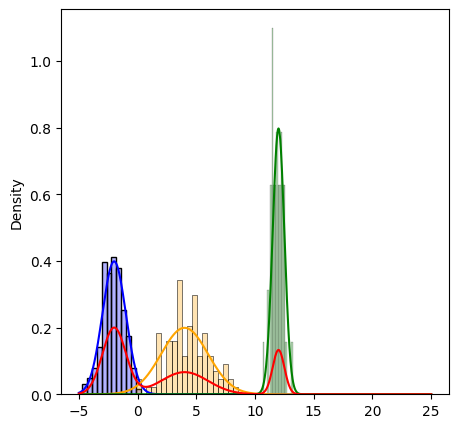

In [109]:
w1 = n1 / (n1 + n2 + n3)
w2 = n2 / (n1 + n2 + n3)
w3 = n3 / (n1 + n2 + n3)

x = np.linspace(-5, 25, 1000)
fig = plt.figure(figsize=(5,5))


sns.histplot(cluster_1, stat='density', alpha=0.3, color='blue')
plt.plot(x, f_1.pdf(x), color='blue')
#plt.scatter(cluster_1, np.zeros(len(cluster_1)), color='red', marker='o')

sns.histplot(cluster_2, stat='density', bins=20,alpha=0.3, color='orange',)
plt.plot(x, f_2.pdf(x), color='orange')

sns.histplot(cluster_3, stat='density', bins=20,alpha=0.3, color='green',)
plt.plot(x, f_3.pdf(x), color='green')

plt.plot(x, w1*f_1.pdf(x) + w2*f_2.pdf(x) + w3*f_3.pdf(x), color = 'red')

plt.show()


In [110]:
data = np.concatenate((cluster_1.numpy(), cluster_2.numpy(), cluster_3.numpy()))

print(np.mean(data), np.var(data))

2.3657382 27.928776


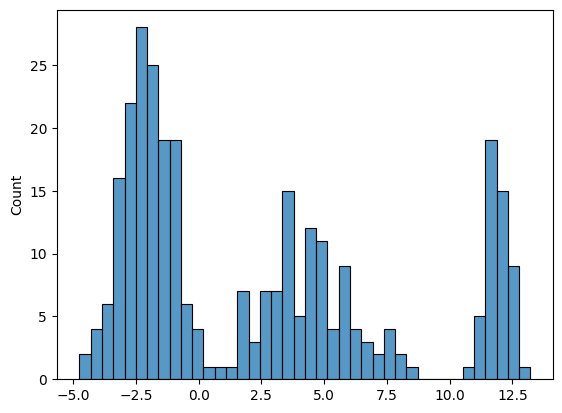

In [111]:
fig = plt.figure()

sns.histplot(data, bins=40)
plt.show()

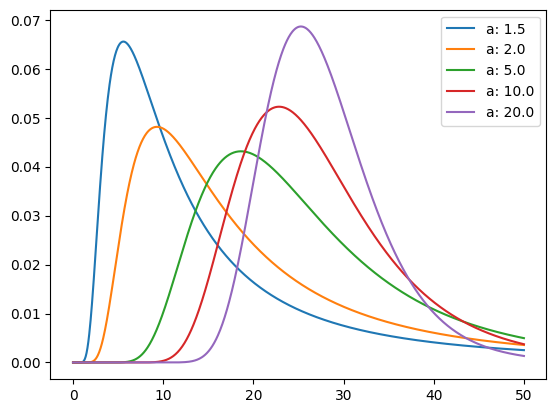

In [112]:
mu_hat= np.mean(data)
var_hat = np.var(data)

sigrange = np.linspace(0.001, 50, 1000)

for a in [1.5, 2.0, 5.0, 10.0, 20.0]:
    b = var_hat * (a - 1)
    plt.plot(sigrange, tfp.distributions.InverseGamma(a, b).prob(sigrange), label="a: {0}".format(a))

plt.legend()
plt.show()

In [113]:
a = 5
b = var_hat * (a - 1)
print(b)

111.71510314941406


In [114]:
def Gibbs_Sampler(data, n_clus, niter, burnin):
    alpha = np.ones(n_clus) 
    weights = np.ones(n_clus) / n_clus
    cluster_allocs = tfp.distributions.Categorical(probs = weights).sample(len(data))

    cluster_allocs_out = []
    mu_out = []
    tau_out = []
    weights_out = []

    mu0 = np.median(data)
    tau0 = tfp.distributions.Gamma(a,b).sample().numpy()

    for i in range(niter):
        print("\rIter {0} / {1}".format(i+1, niter), flush=True, end=" ")

        n_in_clus = np.sum(cluster_allocs == np.arange(n_clus)[:, np.newaxis], axis=1)
        weights = tfp.distributions.Dirichlet(alpha+n_in_clus).sample().numpy()

        mu_iter = []
        tau_iter = []

        # one step Gibbs
        for j in range(n_clus):
            clusdata = data[cluster_allocs == j]
            if len(clusdata) == 0:
                clusmean = 0
            else:
                clusmean = np.mean(clusdata)
        
            tau_clus = tfp.distributions.Gamma(a+len(clusdata)/2, b+0.5*(np.sum((clusdata-clusmean)**2))).sample().numpy()
            delta = (len(clusdata)*tau_clus) / (tau0 + len(clusdata)*tau_clus)
            mu_clus = tfp.distributions.Normal(delta*clusmean+(1-delta)*mu0, 1/(tau0+len(clusdata)*tau_clus)).sample().numpy()
    
            tau_iter.append(1/tau_clus)
            mu_iter.append(mu_clus)

        logprobs = tfp.distributions.Normal(mu_iter, tau_iter).log_prob(data[:, np.newaxis])
        probs = np.exp(np.log(weights) + logprobs)
        probs /= np.sum(probs, axis=1)[:, np.newaxis]
        cluster_allocs = tfp.distributions.Categorical(probs=probs).sample()
        
        if (niter > burnin):
            weights_out.append(weights)
            tau_out.append(tau_iter)
            mu_out.append(mu_iter)
            cluster_allocs_out.append(cluster_allocs)

    return cluster_allocs_out, mu_out, tau_out, weights_out

In [115]:
n_clus = 3
niter = 10
burnin = 1
z, mu, tau, w = Gibbs_Sampler(data, n_clus, niter, burnin)

Iter 10 / 10 

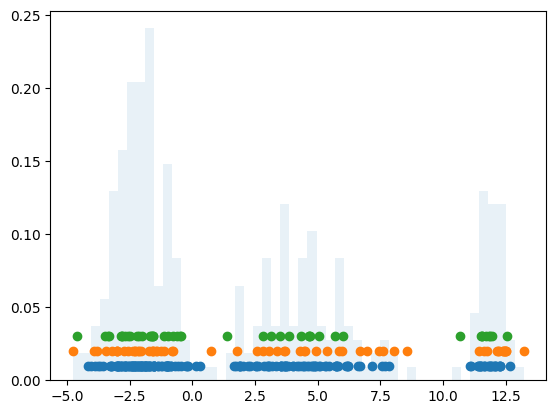

In [116]:
plt.hist(data, density=True, alpha=0.1, bins=50)
for h in range(3):
    currd = data[z[-1] == h]
    plt.scatter(currd,  np.zeros_like(currd) + 0.01 * (h+1))